In [2]:
import matplotlib.pylab as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from kaggle_environments import make
from kaggle_environments.envs.kore_fleets.helpers import *
import numpy as np
import skimage
import itertools
from copy import deepcopy
import pickle

# Load the board

In [3]:
env = make("kore_fleets", debug=True)
print(env.name, env.version)

kore_fleets 1.2.0


In [4]:
env.render(mode="ipython", width=1000, height=800)

In [5]:
board = np.array(env.state[0]['observation']['kore']).reshape((21,21))

In [6]:
board.transpose()

array([[ 5,  0,  0,  0,  9, 30, 29,  0,  0,  0,  0,  0,  0,  0, 29, 30,
         9,  0,  0,  0,  5],
       [ 0,  0,  0,  9,  0,  0, 10, 19,  0, 11,  0, 11,  0, 19, 10,  0,
         0,  9,  0,  0,  0],
       [ 0,  0,  2,  0,  0,  1, 40,  0,  0,  0,  7,  0,  0,  0, 40,  1,
         0,  0,  2,  0,  0],
       [ 0,  9,  0,  0,  0,  0,  0, 19,  0,  0,  0,  0,  0, 19,  0,  0,
         0,  0,  0,  9,  0],
       [ 9,  0,  0,  0,  0,  0, 12, 28, 19,  1,  0,  1, 19, 28, 12,  0,
         0,  0,  0,  0,  9],
       [30,  0,  1,  0,  0,  0,  5,  0,  0,  0,  0,  0,  0,  0,  5,  0,
         0,  0,  1,  0, 30],
       [29, 10, 40,  0, 12,  8, 17,  0,  0,  0,  0,  0,  0,  0, 17,  8,
        12,  0, 40, 10, 29],
       [ 0, 19,  0, 19,  0,  1,  3,  0,  2,  0,  2,  0,  2,  0,  3,  1,
         0, 19,  0, 19,  0],
       [ 0,  0,  0,  0,  3,  8,  0, 14, 20, 13, 17, 13, 20, 14,  0,  8,
         3,  0,  0,  0,  0],
       [ 0, 11,  0,  0,  0,  0,  0,  0,  5, 23,  0, 23,  5,  0,  0,  0,
         0,  0,  0,

# Vein detection

In [7]:
binary_board = board.copy()
binary_board[np.where(board > 0)] = 1
veins = skimage.measure.label(binary_board, background=0, connectivity=1)

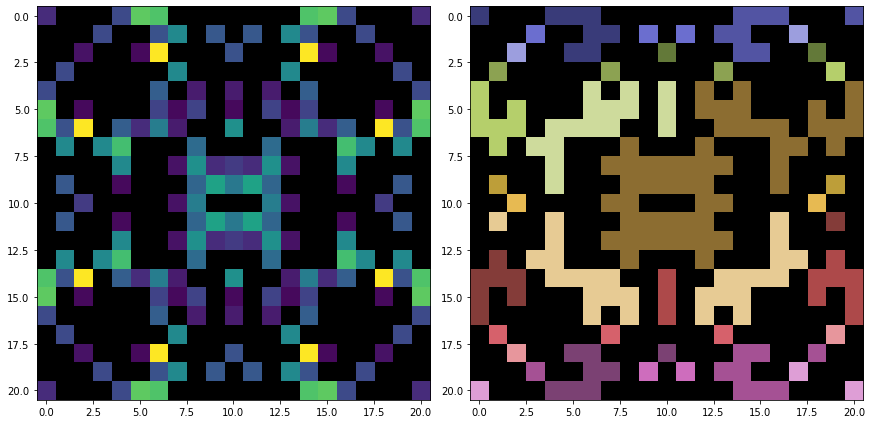

In [8]:
colors = cm.get_cmap('tab20b', 256)
newcolors = colors(np.linspace(0, 1, 256))
black = np.array([[0, 0, 0, 1]])
newcolors[:1, :] = black
veinscmp = ListedColormap(newcolors)
colors = cm.get_cmap('viridis', 256)
newcolors = colors(np.linspace(0, 1, 256))
newcolors[:1, :] = black
boardcmp = ListedColormap(newcolors)

fig, axs = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)
axs[0].imshow(board, cmap=boardcmp)
axs[1].imshow(veins, cmap=veinscmp)

In [9]:
def pairwise(iterable):
    a, b = itertools.tee(iterable)
    next(b, None)
    return zip(a, b)

def step_direction(start, end):
    if start[0] - end[0] < 0:
        return 'E'
    
    if start[0] - end[0] > 0:
        return 'W'

    if start[1] - end[1] < 0:
        return 'N'

    if start[1] - end[1] > 0:
        return 'S'

def walk_to_flight_plan(walk):
    flight_plan = ""
    prev_dir = None
    dir_count = 0

    for current, next in pairwise(walk):
        curr_dir = step_direction(current, next)

        if prev_dir is not None and curr_dir != prev_dir:
            suffix = str(dir_count) if dir_count > 1 else ''
            flight_plan += prev_dir + suffix
            dir_count = 1
        else:
            dir_count += 1

        prev_dir = curr_dir

    suffix = str(dir_count) if dir_count > 1 else ''
    flight_plan += prev_dir + suffix

    return flight_plan

In [10]:
def fuse_walks(pos, walks):
    new_walks = []

    for w in walks:
        new_walks += [[pos] + w]

    return new_walks

def distance(p1, p2):
    return abs(p1[0] - p2[0]) + abs(p1[1] - p2[1])

def list_walks(grid_shape, start, end, max_length=10, first_call=True):
    m, n = grid_shape
    
    if max_length == 0 or (not first_call and start == end):
        return [[start]]

    adj_pos = list()
    
    if start[0] - 1 >= 0:
        adj_pos += [(start[0] - 1, start[1])]

    if start[0] + 1 <= m - 1:
        adj_pos += [(start[0] + 1, start[1])]

    if start[1] - 1 >= 0:
        adj_pos += [(start[0], start[1] - 1)]
        
    if start[1] + 1 <= n - 1:
        adj_pos += [(start[0], start[1] + 1)]

    walks = list()

    for p in adj_pos:
        if distance(p, end) <= max_length - 1:
            walks += fuse_walks(start, list_walks(grid_shape, p, end, max_length - 1, first_call=False))

    return walks

In [11]:
%%time
walks = list_walks((11, 11), (5, 5), (5, 5), max_length=10)

CPU times: user 261 ms, sys: 11.8 ms, total: 272 ms
Wall time: 270 ms


In [12]:
len(walks)

24140

In [13]:
walks[51]

[(5, 5),
 (4, 5),
 (3, 5),
 (2, 5),
 (3, 5),
 (2, 5),
 (2, 6),
 (3, 6),
 (4, 6),
 (5, 6),
 (5, 5)]

In [14]:
%%time
walk_to_flight_plan(walks[51])

CPU times: user 11 µs, sys: 8 µs, total: 19 µs
Wall time: 21.5 µs


'W3EWNE3S'

# Walks generation

This section aims at generating a large amount of possible walk on the game board that will be used to mine. All the walks are board independant and then can be precomputed. At play time, the walks will be ranked according to the amount of kore they mine and other environmental aspects.

## Flight plan length limit

A valid walk must have a flight plan limited in length by the following function, which depend on the number of ships in the moving fleet.

In [15]:
def max_fp_len(fleet_size):
    return int(np.floor(2 * np.log(fleet_size)) + 1)

In [16]:
max_fp_len(16)

6

Which correspond to the following plot

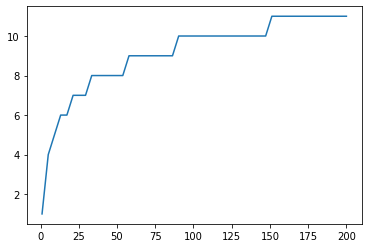

In [17]:
X = np.linspace(1, 200)
Y = map(max_fp_len, X)
plt.plot(X, list(Y))
plt.show()

## Precomputed walks

In the next couple of cells, we implement board exploration algorithms in order to precomputed walks that will be used at play time (note that not all possibilities are taken into account, that would take too long to compute)
Different "class" of walk are computed :
- Walks that lie in a 11x11 square centered on a shipyard
- Walks that lie in a 5x16 rectangle with a shipyard on one of the narrow side
- L shaped walks (boomerangs)
- Loop shaped walks

In [18]:
class Walk:
    def __init__(self):
        self.walk = list()
        self.kore = 0
        self.flight_plan = ''
        self.sub_flight_plans = list() # example : [['N', 1], ['E', 3], ['S', 1]]
        self.valid = True

    def _add_first_step(self, pos):
        if len(self.walk) != 0 and pos == self.walk[0]:
            self.valid = False

        self.walk = [pos] + self.walk
        
        if len(self.walk) >= 2:
            first_dir = step_direction(pos, self.walk[1])

            if len(self.sub_flight_plans) == 0:
                self.sub_flight_plans = [[first_dir, 1]]
            elif first_dir == self.sub_flight_plans[0][0]:
                self.sub_flight_plans[0][1] += 1
            else:
                self.sub_flight_plans = [[first_dir, 1]] + self.sub_flight_plans

    def _add_step(self, pos):
        if len(self.walk) != 0 and pos == self.walk[-1]:
            self.valid = False

        self.walk += [pos]

        if len(self.walk) >= 2:
            last_dir = step_direction(self.walk[-2], pos)

            if len(self.sub_flight_plans) == 0:
                self.sub_flight_plans = [[last_dir, 1]]
            elif last_dir == self.sub_flight_plans[-1][0]:
                self.sub_flight_plans[-1][1] += 1
            else:
                self.sub_flight_plans += [[last_dir, 1]]

        
    def add_step(self, pos, kore=0, first_step=False):
        if first_step:
            self._add_first_step(pos)
        else:
            self._add_step(pos)

        self.kore += kore

        if self.valid:
            self.flight_plan = self._canonical_flight_plan()
        else:
            self.flight_plan = ''

        return self.valid

    def _canonical_flight_plan(self):
        fp_str = ''

        if len(self.walk) < 2:
            return fp_str

        for d, c in self.sub_flight_plans[:-1]:
            suffix = str(c - 1) if c > 1 else ''
            fp_str += d + suffix

        fp_str += self.sub_flight_plans[-1][0] # No need for the integer on the last straight line

        return fp_str

    def flight_plan_len(self):
        return len(self.flight_plan)

    def __len__(self):
        return len(self.walk) - 1

    def __str__(self):
        return str(self.walk)

    def __repr__(self):
        return str(self.walk)

    def copy(self):
        c = Walk()
        c.walk = self.walk.copy()
        c.kore = self.kore
        c.flight_plan = self.flight_plan
        c.sub_flight_plans = deepcopy(self.sub_flight_plans)
        c.valid = self.valid

        return c
        
def fuse_valid_walks(pos, walks, max_fp_len):
    new_walks = []

    for w in walks:
        wc = w.copy()
        valid = wc.add_step(pos, first_step=True)

        if valid and wc.flight_plan_len() <= max_fp_len:
            # print("VALID", wc, len(wc)) 
            new_walks += [wc]
        # else:
        #     print("INVALID", wc, wc.flight_plan, wc.flight_plan_len(), wc.valid, len(wc))

    return new_walks

WALKS_CACHE = dict()
cache_access_count = 0

# TODO : Symetry can be used to reduce compute time ?
def list_mining_walks_rec(grid_shape, start, end, max_length=10, max_fp_len=7, first_call=True, _starting_pos=None, use_cache=True):
    global WALKS_CACHE
    global cache_access_count
    
    m, n = grid_shape
    
    if first_call:
        WALKS_CACHE = dict()
        _starting_pos = start
        
    if max_length == 0 or (not first_call and start == end):
        w = Walk()
        w.add_step(start)
        return [w]

    adj_pos = list()
    
    if start[0] - 1 >= 0:
        adj_pos += [(start[0] - 1, start[1])]

    if start[0] + 1 <= m - 1:
        adj_pos += [(start[0] + 1, start[1])]

    if start[1] - 1 >= 0:
        adj_pos += [(start[0], start[1] - 1)]
        
    if start[1] + 1 <= n - 1:
        adj_pos += [(start[0], start[1] + 1)]

    walks = list()

    for p in adj_pos:
        if _starting_pos != end:
            no_return = p != _starting_pos
        else:
            no_return = True

        if distance(p, end) <= max_length - 1 and no_return:
            key = (p, max_length - 1)

            if use_cache and key in WALKS_CACHE:
                cache_access_count += 1
                p_walks = WALKS_CACHE[key]
            else:
                p_walks = list_mining_walks_rec(grid_shape, p, end, max_length - 1, first_call=False, _starting_pos=_starting_pos)

                if use_cache:
                    WALKS_CACHE[key] = [w.copy() for w in p_walks]

            new_walks = fuse_valid_walks(start, p_walks, max_fp_len)
            walks += new_walks

    return walks

def list_mining_walks(grid_shape, start, end, max_length=10, max_fp_len=7):
    m, n = grid_shape

    w = Walk()
    w.add_step(start)
    walk_stack = [w]
    final_walks = list()
    rejected = list()

    while len(walk_stack) > 0:
        new_walk_stack = list()

        for walk in walk_stack:
            last_pos = walk.walk[-1]
            adj_pos = list()
    
            if last_pos[0] - 1 >= 0:
                adj_pos += [(last_pos[0] - 1, last_pos[1])]

            if last_pos[0] + 1 <= m - 1:
                adj_pos += [(last_pos[0] + 1, last_pos[1])]

            if last_pos[1] - 1 >= 0:
                adj_pos += [(last_pos[0], last_pos[1] - 1)]
                
            if last_pos[1] + 1 <= n - 1:
                adj_pos += [(last_pos[0], last_pos[1] + 1)]

            for next_pos in adj_pos:
                finished_walk = next_pos == end

                if not finished_walk and next_pos == start:
                    continue

                new_walk = walk.copy()
                new_walk.add_step(next_pos)

                if not new_walk.valid or len(walk) + distance(next_pos, end) >= max_length or new_walk.flight_plan_len() > max_fp_len:
                    rejected += [new_walk]
                    continue

                if finished_walk:
                    final_walks += [new_walk]
                else:
                    new_walk_stack += [new_walk]

        walk_stack = new_walk_stack

    return final_walks

## All valid walks

In [19]:
%%timeit -t 
valid_walks = list_mining_walks_rec((11, 11), (5, 5), (5, 5), max_length=10, max_fp_len=7, use_cache=True)

922 ms ± 12.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
%%timeit -t
valid_walks = list_mining_walks_rec((11, 11), (5, 5), (5, 5), max_length=10, max_fp_len=7, use_cache=False)

866 ms ± 20.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
%%timeit -t
valid_walks = list_mining_walks((11, 11), (5, 5), (5, 5), max_length=10, max_fp_len=7)

KeyboardInterrupt: 

In [ ]:
%%time
walks20 = list_mining_walks_rec((11, 11), (5, 5), (5, 5), max_length=12, max_fp_len=7)

CPU times: user 4.37 s, sys: 105 µs, total: 4.37 s
Wall time: 4.36 s


In [ ]:
len(walks20)

2216

In [ ]:
len(walks20), max([len(w) for w in walks20]), max([w.flight_plan_len() for w in walks20])

(1052, 14, 7)

In [ ]:
len(walks20), max([len(w) for w in walks20]), max([w.flight_plan_len() for w in walks20])

(2884, 20, 7)

In [ ]:
walks1 = list_mining_walks_rec((11, 11), (1, 1), (8, 6), max_length=12, max_fp_len=7, use_cache=False)
walks2 = list_mining_walks((11, 11), (1, 1), (8, 6), max_length=12, max_fp_len=7)
len(walks1), len(walks2)

(100, 100)

In [ ]:
len(walks1), max([len(w) for w in walks1]), max([w.flight_plan_len() for w in walks1])

(100, 12, 7)

In [ ]:
len(walks2), max([len(w) for w in walks2]), max([w.flight_plan_len() for w in walks2])

(100, 12, 7)

In [ ]:
w1 = [w.walk for w in walks1]
w2 = [w.walk for w in walks2]
diff1, diff2 = [w for w in walks1 if w.walk not in w2], [w for w in walks2 if w.walk not in w1]
print(len(diff1), len(diff2))
print("hehehe")

0 136
hehehe


In [ ]:
%%timeit -t
valid_walks = list_mining_walks_rec((21, 21), (10, 10), (10, 10), max_length=20, max_fp_len=10, use_cache=False)

544 ms ± 23.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
# %%timeit
# valid_walks = list_mining_walks((11, 11), (5, 5), (5, 5), max_length=20, max_fp_len=10)

In [ ]:
# valid_walks = list_mining_walks_rec((21, 21), (5, 5), (5, 5), max_length=50, max_fp_len=7, use_cache=True)
valid_walks = list_mining_walks_rec((11, 11), (5, 5), (5, 5), max_length=15, max_fp_len=8)
# walks = [(w, mined_kore_on_walk(w.walk, board[:11,:11], 50) / len(w)) for w in valid_walks]
# walks = sorted(walks, key=lambda x: x[1])[::-1]

In [ ]:
valid_walks[42].walk

[(5, 5),
 (4, 5),
 (3, 5),
 (2, 5),
 (1, 5),
 (0, 5),
 (0, 4),
 (0, 5),
 (1, 5),
 (2, 5),
 (3, 5),
 (4, 5),
 (5, 5)]

In [ ]:
valid_walks[42].flight_plan

'W4SNE'

In [ ]:
pickle.dump(valid_walks, open("all_walks.pkl", "wb"))

In [ ]:
len(valid_walks)

8756

# Ranking mining walks

Now that our walks are generated once and for all, we need to rank them according to the map kore distribution. The ranking is done on the kore/step given by each walk.

In [ ]:
all_walks = pickle.load(open("all_walks.pkl", "rb"))
len(all_walks)

8756

## Mining rate

In [ ]:
def mining_rate(fleet_size):
    return np.log(fleet_size) / 20

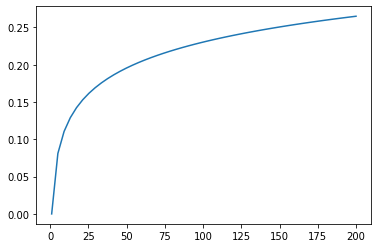

In [ ]:
X = np.linspace(1, 200)
Y = map(mining_rate, X)
plt.plot(X, list(Y))
plt.show()

## Mining simulation

Mine kore along the walk according to the mining rate and regenerate the board after each step

In [ ]:
def mined_kore_on_walk(walk, board, fleet_size):
    board_copy = deepcopy(np.asarray(board, dtype=np.float32))
    mr = mining_rate(fleet_size)
    kore = 0
    
    for p in walk[1:-1]:
        kore_mined = mr * board_copy[p[0], p[1]]
        kore += kore_mined
        board_copy[p[0], p[1]] -= kore_mined
        board_copy += board_copy * 0.02

    return kore

In [ ]:
def kore_on_walk(walk, board):
    board_copy = deepcopy(np.asarray(board, dtype=np.float32))
    kore = 0
    
    for p in walk[1:-1]:
        kore += board_copy[p[0], p[1]]

    return kore

## Ranking methods

### Bruteforce ranking

Simply simulate the kore/step of each walk and sort them

In [ ]:
def rank_mining_walks_bf(walks, board, fleet_size):
    ranked_walks = [(w, mined_kore_on_walk(w.walk, board, fleet_size) / len(w)) for w in walks]
    ranked_walks = sorted(ranked_walks, key=lambda x: x[1])[::-1]

    return ranked_walks

In [ ]:
%%timeit -t
rank_mining_walks_bf(all_walks, board[:11, :11], 50)

493 ms ± 7.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Reduce and rank

Precompute a hash table of what walks go through each cell of the board

In [ ]:
pos_to_walk = dict()

for i, walk in enumerate(all_walks):
    for p in walk.walk:
        pos_to_walk[p] = pos_to_walk.get(p, []) + [i]

Then, at play time, select only walks that go through kore cells, simulate them and rank them

In [ ]:
def rank_mining_walks_rd(walks, board, fleet_size, pos_to_walk):
    reduced_walks = list()
    walk_indices = list()

    for i, j in zip(range(board.shape[0]), range(board.shape[1])):
        if board[i, j] > 0 and (i, j) in pos_to_walk:
            walk_indices += pos_to_walk[(i, j)]

    walk_indices = list(set(walk_indices))
    reduced_walks = [walks[i] for i in walk_indices]
    ranked_walks = [(w, mined_kore_on_walk(w.walk, board, fleet_size) / len(w), kore_on_walk(w.walk, board) / len(w)) for w in reduced_walks]
    ranked_walks = sorted(ranked_walks, key=lambda x: x[1])[::-1]

    return ranked_walks

In [ ]:
%%timeit -t
rank_mining_walks_rd(all_walks, board[:11, :11], 50, pos_to_walk)

147 ms ± 656 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


As a result, we might get up to 3x speedup depending on the kore map.

### Reduce, split by fp length and rank

Since 'sorted' function is O(n log(n)) and it might also be convenient to have walks with different flight plan length in different lists, we can split walks by length and gain a bit of time as well when sorting

In [ ]:
def rank_mining_walks_rs(walks, board, fleet_size, pos_to_walk):
    reduced_walks = list()
    walk_indices = list()

    for i, j in zip(range(board.shape[0]), range(board.shape[1])):
        if board[i, j] > 0 and (i, j) in pos_to_walk:
            walk_indices += pos_to_walk[(i, j)]

    walk_indices = list(set(walk_indices))
    reduced_walks = [walks[i] for i in walk_indices]

    ranked_walks = dict()
    for w in reduced_walks:
        ranked_walks[w.flight_plan_len()] = ranked_walks.get(w.flight_plan_len(), []) + [(w, mined_kore_on_walk(w.walk, board, fleet_size) / len(w))]

    for k in ranked_walks:
        ranked_walks[k] = sorted(ranked_walks[k], key=lambda x: x[1])[::-1]

    return ranked_walks

In [ ]:
%%timeit -t
rank_mining_walks_rs(all_walks, board[:11, :11], 50, pos_to_walk)

160 ms ± 885 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Visualisation

Let's check if both methods return the same mining walks.

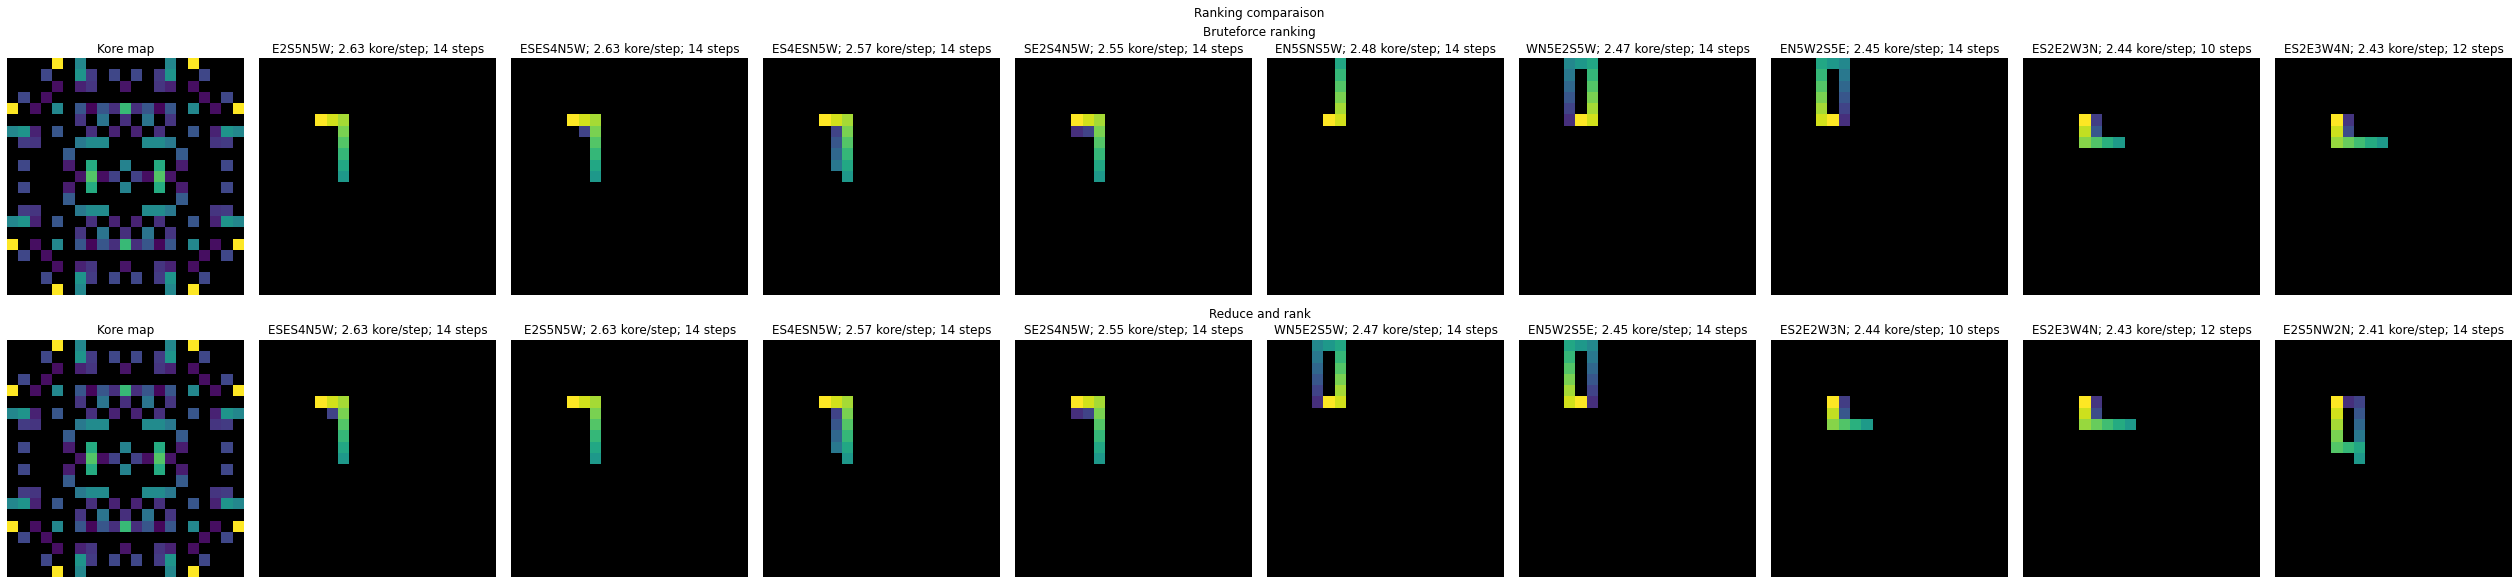

In [ ]:
N = 10
bf_ranked_walks = rank_mining_walks_bf(valid_walks, board[:11, :11], 50)
rd_ranked_walks = rank_mining_walks_rd(valid_walks, board[:11, :11], 50, pos_to_walk)

fig = plt.figure(constrained_layout=True, figsize=(35, 8))
fig.suptitle('Ranking comparaison')

titles = ['Bruteforce ranking', 'Reduce and rank']
all_ranked_walks = [bf_ranked_walks, rd_ranked_walks]

subfigs = fig.subfigures(nrows=2, ncols=1)
for row, subfig in enumerate(subfigs):
    subfig.suptitle(titles[row])
    sub_walk = all_ranked_walks[row]

    axs = subfig.subplots(nrows=1, ncols=N)
    axs[0].imshow(board, cmap=boardcmp, interpolation='none')
    axs[0].axis('off')
    axs[0].set_title('Kore map')

    for i in range(1, 10):
        ax_walk = np.asarray(sub_walk[i - 1][0].walk)
        path = np.zeros(board.shape)

        for k, p in enumerate(ax_walk):
            path[p[0], p[1]] = (k + 1)
            
        axs[i].imshow(path, cmap=boardcmp, interpolation='none')
        axs[i].set_title(sub_walk[i - 1][0].flight_plan + f'; {sub_walk[i - 1][1]:.2f} kore/step; {len(sub_walk[i - 1][0])} steps')
        axs[i].axis('off')

One walk seems to be missing from the reduce method... Have to check that

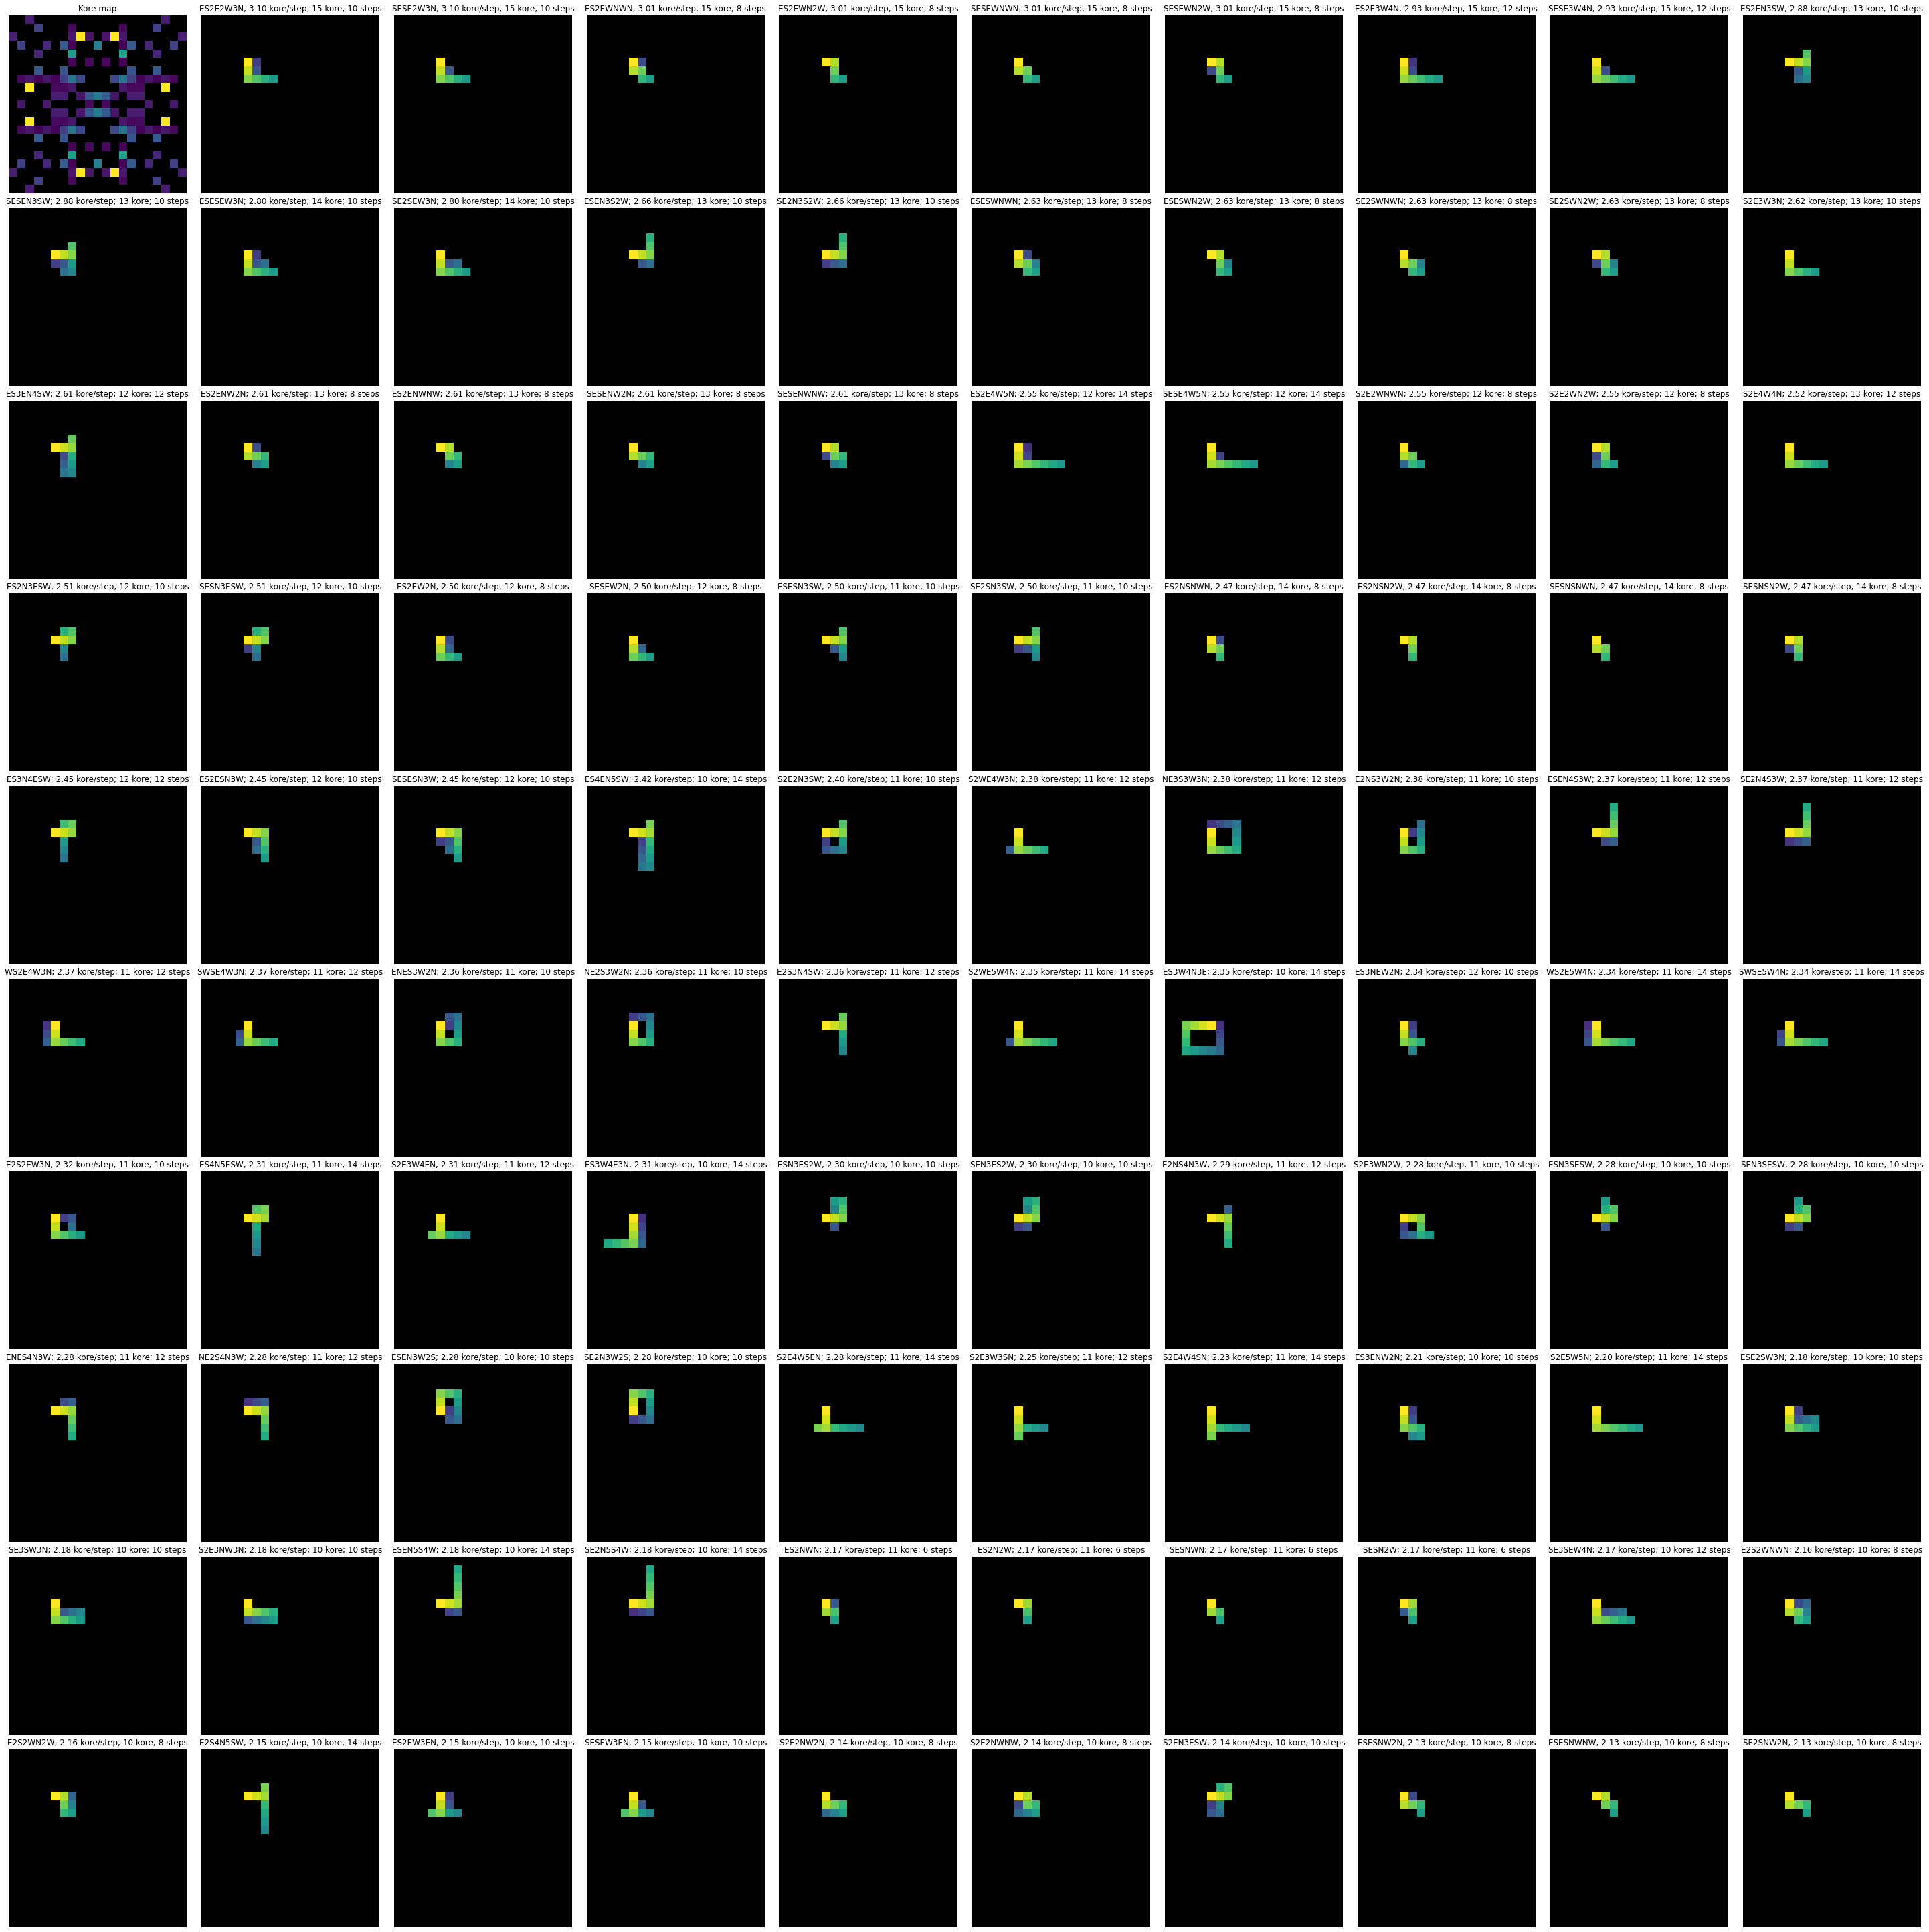

In [ ]:
N = 10
rd_ranked_walks = rank_mining_walks_rd(all_walks, board[:11, :11], 50, pos_to_walk)

fig, axs = plt.subplots(N, N, figsize=(40, 40), constrained_layout=True)
axs[0, 0].imshow(board, cmap=boardcmp, interpolation='none')
axs[0, 0].axis('off')
axs[0, 0].set_title('Kore map')

for idx in range(1, N * N):
    i, j = idx // N, idx % N
    walk = np.asarray(rd_ranked_walks[idx - 1][0].walk)
    path = np.zeros(board.shape)
    
    for k, p in enumerate(walk):
        path[p[0], p[1]] = (k + 1)

    axs[i, j].imshow(path, cmap=boardcmp, interpolation='none')
    axs[i, j].set_title(rd_ranked_walks[idx-1][0].flight_plan + f'; {rd_ranked_walks[idx - 1][1]:.2f} kore/step; {int(rd_ranked_walks[idx - 1][2])} kore; {len(rd_ranked_walks[idx - 1][0])} steps')
    axs[i, j].axis('off')

In [ ]:
flight_plans = [w.flight_plan for w in valid_walks]

In [ ]:
len(flight_plans), len(set(flight_plans))

(1584, 1584)

In [ ]:
np.asarray(valid_walks[0].walk) + 5


array([[10, 10],
       [ 9, 10],
       [10, 10]])

In [ ]:
axs

array([[<AxesSubplot:title={'center':'Kore map'}>,
        <AxesSubplot:title={'center':'W2EWE2; 2.35 kore/step; 6 steps'}>,
        <AxesSubplot:title={'center':'N2SNS2; 2.35 kore/step; 6 steps'}>,
        <AxesSubplot:title={'center':'W2E2; 2.30 kore/step; 4 steps'}>,
        <AxesSubplot:title={'center':'N2S2; 2.30 kore/step; 4 steps'}>,
        <AxesSubplot:title={'center':'W2NSE2; 2.27 kore/step; 6 steps'}>,
        <AxesSubplot:title={'center':'N2WES2; 2.27 kore/step; 6 steps'}>,
        <AxesSubplot:title={'center':'WNENS2; 2.21 kore/step; 6 steps'}>,
        <AxesSubplot:title={'center':'NWSWE2; 2.21 kore/step; 6 steps'}>,
        <AxesSubplot:title={'center':'W2ENES; 2.19 kore/step; 6 steps'}>],
       [<AxesSubplot:title={'center':'N2SWSE; 2.19 kore/step; 6 steps'}>,
        <AxesSubplot:title={'center':'W3E2WE2; 2.06 kore/step; 8 steps'}>,
        <AxesSubplot:title={'center':'N3S2NS2; 2.06 kore/step; 8 steps'}>,
        <AxesSubplot:title={'center':'W2SNE2; 2.06 kore/step; 

In [ ]:
len(valid_walks)

1584

In [ ]:
def agent(obs, config):
    board = Board(obs, config)
    me=board.current_player

    me = board.current_player
    turn = board.step
    spawn_cost = board.configuration.spawn_cost
    kore_left = me.kore

    for shipyard in me.shipyards:
        if kore_left >= spawn_cost:
            action = ShipyardAction.spawn_ships(1)
            shipyard.next_action = action
        elif shipyard.ship_count > 0:
            direction = Direction.NORTH
            action = ShipyardAction.launch_fleet_with_flight_plan(2, direction.to_char())
            shipyard.next_action = action

    return me.next_actions